In [28]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import librosa
import sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import pandas
import seaborn as sns
import csv
from sklearn import svm
import itertools
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import pandas as pd
from scipy.special import comb
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif, mutual_info_classif, SelectPercentile, GenericUnivariateSelect
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from scipy.stats import rankdata
from matplotlib import style
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [2]:
DATADIR = "DATASET1"
CATEGORIES = ["Segmented_Laugh", "Segmented_NonLaugh1"]

# Defining Functions

In [3]:
def createcombinations(n):
    elements = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
    a = list(itertools.combinations(elements, n))
    a = np.asarray(a).astype(int)
    return a

In [94]:
def create_training_data(t_frame, t_shift, n_mfccs, component, training_data, n_features):
    count=0
    error_count = 0
    laugh_counter = 0
    nonlaugh_counter = 0
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category) 
        class_num = CATEGORIES.index(category)
        for aud in os.listdir(path):
            if aud == '.DS_Store':
                continue
            
            aud_array , sr = librosa.load(os.path.join(path,aud), sr=None)
            count+=1

            mfccs = []
            
            try:
                mfcc = (librosa.feature.mfcc(aud_array, sr=sr,  n_mfcc=20,  win_length = int(sr*t_frame), hop_length = int(sr*t_shift))) 
                
                mfcc_temp = mfcc[component,:]
                mean_mfccs = np.mean(np.asarray(mfcc_temp),axis = 1)
                std_mfccs = np.std(np.asarray(mfcc_temp), axis = 1)
                #var_mfccs = np.var(np.asarray(mfcc_temp), axis = 1)
                
                mfcc_delta = librosa.feature.delta(mfcc_temp)
                #mfcc_delta_var = np.var(np.asarray(mfcc_delta),axis = 1)
                mfcc_delta_std = np.std(np.asarray(mfcc_delta),axis = 1)
                
                mfcc_delta2 = librosa.feature.delta(mfcc_delta)
                #mfcc_delta2_mean = np.mean(np.asarray(mfcc_delta2),axis = 1)
                #mfcc_delta2_var = np.var(np.asarray(mfcc_delta2),axis = 1)
                mfcc_delta2_std = np.std(np.asarray(mfcc_delta2),axis = 1)
                
                
                mfccs.append(mean_mfccs)
                mfccs.append(std_mfccs)
                mfccs.append(mfcc_delta_std)
                mfccs.append(mfcc_delta2_std)
                
                mfccs = np.asarray(mfccs).reshape(n_mfccs*n_features,1)
                
                training_data.append([mfccs.reshape(-1,1), class_num])
                if category == 'Segmented_Laugh':
                    laugh_counter +=1
                else:
                    nonlaugh_counter += 1
                    if nonlaugh_counter >= laugh_counter:
                        break

            except ValueError:
                pass
            
    return laugh_counter, nonlaugh_counter
    

# Main Loop

In [95]:
def scaling(X,n_mfcc):
    for i in range(n_mfcc):
        X[:,i] = X[:,i]/(np.mean(X[:,i]))
        

    #X[:,1] = np.square(X[:,1])
        
    return X

In [96]:
n_features = 4
t_frame = 0.025
t_shift = 0.01
n_mfcc = 20
component = createcombinations(n_mfcc)

for components in component:
    training_data = []
    laugh, nonlaugh = create_training_data(t_frame, t_shift, n_mfcc, components, training_data, n_features)
    print(laugh, nonlaugh)
    
random.shuffle(training_data) 
X = []
Y = []
for features, label in training_data:
    X.append(features)
    Y.append(label)
        
X = np.array(X).reshape(-1,n_mfcc*n_features)
Y = np.array(Y)
X = scaling(X,n_mfcc)

779 779


In [97]:
X.shape

(1558, 80)

In [98]:
 ##Using SFS ( is forward = True ) and SBS ( if forward = False)

In [99]:
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.2, random_state=42)

In [100]:
X_train.shape

(1246, 80)

In [117]:
k_range = range(1,70)
scores = {}
scores_list = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k, weights='uniform', p = 1)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores[k] = metrics.roc_auc_score(y_test, y_pred)
    scores_list.append(metrics.roc_auc_score(y_test, y_pred))
    #scores[k] = metrics.accuracy_score(y_test, y_pred)
    #scores_list.append(metrics.accuracy_score(y_test, y_pred))

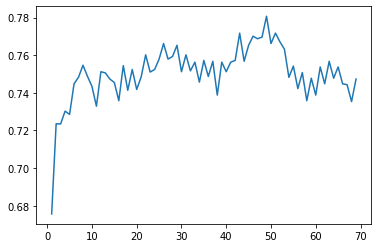

In [118]:
plt.plot(k_range, scores_list)

In [112]:
metrics.roc_auc_score(y_test, y_pred)

0.715279785257072

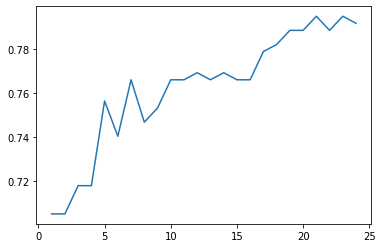

In [53]:
plt.plot(k_range, scores_list)

In [18]:
 classifier = svm.SVC(kernel='linear')
sfs1 = SFS(classifier, 
           k_features=20, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',#scoring='accuracy',
           n_jobs = -1
           )

sfs1 = sfs1.fit(X, Y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   37.2s finished

[2020-01-03 22:45:05] Features: 1/20 -- score: 0.7805724761421953[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:   27.0s finished

[2020-01-03 22:45:33] Features: 2/20 -- score: 0.8046231978797016[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:   24.5s finished

[2020-01-03 22:45:57] Features: 3/20 -- score: 0.8176445130640679[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 out of  37 | elapsed:   28.7s finished

[2020-01-03 22:46:26] Features: 4/20 -- score: 0.8341273188199066[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(

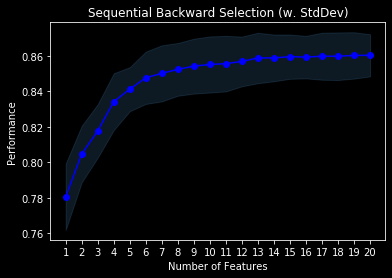

In [22]:
style.use('dark_background')
fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')
plt.title('Sequential Backward Selection (w. StdDev)')
#plt.grid()
plt.show()



In [23]:
df = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T

In [24]:
df

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.780572,0.0239938,"[0.7560815253122947, 0.7654914529914529, 0.777...","(2,)","(2,)",0.018668,0.00933399
2,0.804623,0.0204601,"[0.7952005259697567, 0.7944197896120974, 0.786...","(2, 10)","(2, 10)",0.0159186,0.00795931
3,0.817645,0.0193439,"[0.7971318211702827, 0.8077744904667982, 0.813...","(1, 2, 10)","(1, 2, 10)",0.0150502,0.0075251
4,0.834127,0.0205668,"[0.8183349769888232, 0.8293474687705458, 0.818...","(1, 2, 6, 10)","(1, 2, 6, 10)",0.0160016,0.00800082
5,0.84118,0.0159364,"[0.8272518080210388, 0.8353468113083499, 0.833...","(1, 2, 6, 10, 14)","(1, 2, 6, 10, 14)",0.0123991,0.00619953
6,0.847602,0.0189306,"[0.8404832347140039, 0.8263067061143985, 0.843...","(1, 2, 6, 10, 14, 34)","(1, 2, 6, 10, 14, 34)",0.0147287,0.00736433
7,0.85009,0.0202928,"[0.8429076265614728, 0.8279503616042079, 0.843...","(1, 2, 6, 10, 14, 23, 34)","(1, 2, 6, 10, 14, 23, 34)",0.0157885,0.00789424
8,0.852328,0.0190993,"[0.8475098619329389, 0.8331278763971071, 0.842...","(1, 2, 6, 10, 14, 23, 32, 34)","(1, 2, 6, 10, 14, 23, 32, 34)",0.0148599,0.00742995
9,0.854151,0.0198697,"[0.8531393819855357, 0.8316896778435239, 0.846...","(1, 2, 6, 10, 13, 14, 23, 32, 34)","(1, 2, 6, 10, 13, 14, 23, 32, 34)",0.0154593,0.00772966
10,0.855086,0.0203229,"[0.849646614069691, 0.8327169625246549, 0.8490...","(1, 2, 6, 10, 13, 14, 21, 23, 32, 34)","(1, 2, 6, 10, 13, 14, 21, 23, 32, 34)",0.0158119,0.00790595


In [19]:
style.use('dark_background')
fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')
plt.title('Sequential Backward Selection (w. StdDev)')
#plt.grid()
plt.show()




NameError: name 'style' is not defined

In [196]:
df#MFCC mean, std, Delta std, delta2 std

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.702188,0.0416444,"[0.7019230769230769, 0.7596153846153846, 0.666...","(2,)","(2,)",0.0324007,0.0162004
2,0.737473,0.0373684,"[0.7660256410256411, 0.7756410256410257, 0.717...","(2, 40)","(2, 40)",0.0290739,0.0145369
3,0.761878,0.0387256,"[0.7596153846153846, 0.8141025641025641, 0.75,...","(1, 2, 40)","(1, 2, 40)",0.0301298,0.0150649
4,0.774727,0.0351185,"[0.7692307692307693, 0.8173076923076923, 0.766...","(1, 2, 34, 40)","(1, 2, 34, 40)",0.0273233,0.0136617
5,0.777287,0.0373618,"[0.7788461538461539, 0.8269230769230769, 0.753...","(1, 2, 14, 34, 40)","(1, 2, 14, 34, 40)",0.0290688,0.0145344
6,0.786261,0.0424809,"[0.7884615384615384, 0.8461538461538461, 0.762...","(1, 2, 10, 14, 34, 40)","(1, 2, 10, 14, 34, 40)",0.0330515,0.0165258
7,0.795873,0.0444914,"[0.8012820512820513, 0.8589743589743589, 0.782...","(1, 2, 10, 14, 23, 34, 40)","(1, 2, 10, 14, 23, 34, 40)",0.0346158,0.0173079
8,0.79909,0.0421463,"[0.8076923076923077, 0.8557692307692307, 0.785...","(1, 2, 10, 14, 23, 34, 40, 66)","(1, 2, 10, 14, 23, 34, 40, 66)",0.0327913,0.0163956
9,0.800376,0.0408819,"[0.8076923076923077, 0.8557692307692307, 0.785...","(1, 2, 10, 14, 23, 34, 40, 65, 66)","(1, 2, 10, 14, 23, 34, 40, 65, 66)",0.0318075,0.0159037
10,0.799735,0.0413046,"[0.8076923076923077, 0.8557692307692307, 0.782...","(1, 2, 10, 14, 23, 34, 38, 40, 65, 66)","(1, 2, 10, 14, 23, 34, 38, 40, 65, 66)",0.0321364,0.0160682


In [110]:
df# MFCC mean, std, Delta std

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.698974,0.00904946,"[0.7115384615384616, 0.6923076923076923, 0.692...","(2,)","(2,)",0.00704078,0.00352039
2,0.737481,0.0174033,"[0.7564102564102564, 0.7371794871794872, 0.714...","(2, 40)","(2, 40)",0.0135403,0.00677017
3,0.76249,0.0241902,"[0.7948717948717948, 0.7596153846153846, 0.746...","(1, 2, 40)","(1, 2, 40)",0.0188208,0.00941039
4,0.772754,0.0320291,"[0.8205128205128205, 0.7596153846153846, 0.769...","(1, 2, 34, 40)","(1, 2, 34, 40)",0.0249197,0.0124599
5,0.781092,0.0323187,"[0.8237179487179487, 0.7916666666666666, 0.762...","(1, 2, 34, 40, 43)","(1, 2, 34, 40, 43)",0.0251451,0.0125725
6,0.786241,0.0239067,"[0.8205128205128205, 0.782051282051282, 0.7724...","(1, 2, 10, 34, 40, 43)","(1, 2, 10, 34, 40, 43)",0.0186002,0.0093001
7,0.797151,0.021808,"[0.8269230769230769, 0.7948717948717948, 0.785...","(1, 2, 10, 14, 34, 40, 43)","(1, 2, 10, 14, 34, 40, 43)",0.0169674,0.00848368
8,0.80036,0.0233067,"[0.8301282051282052, 0.7948717948717948, 0.785...","(1, 2, 10, 14, 26, 34, 40, 43)","(1, 2, 10, 14, 26, 34, 40, 43)",0.0181334,0.00906669
9,0.801646,0.0235531,"[0.8301282051282052, 0.7980769230769231, 0.782...","(1, 2, 10, 14, 26, 34, 40, 43, 59)","(1, 2, 10, 14, 26, 34, 40, 43, 59)",0.0183251,0.00916255
10,0.802291,0.0259949,"[0.8333333333333334, 0.8012820512820513, 0.775...","(1, 2, 10, 14, 26, 29, 34, 40, 43, 59)","(1, 2, 10, 14, 26, 29, 34, 40, 43, 59)",0.020225,0.0101125


In [182]:
df#Delta2 std, variance

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.655339,0.0316425,"[0.6410256410256411, 0.6858974358974359, 0.669...","(0,)","(0,)",0.024619,0.0123095
2,0.700873,0.0436955,"[0.717948717948718, 0.7467948717948718, 0.7115...","(0, 21)","(0, 21)",0.0339966,0.0169983
3,0.710471,0.0415302,"[0.7339743589743589, 0.7532051282051282, 0.717...","(0, 14, 21)","(0, 14, 21)",0.0323119,0.016156
4,0.72139,0.0365354,"[0.7435897435897436, 0.7628205128205128, 0.714...","(0, 11, 14, 21)","(0, 11, 14, 21)",0.0284258,0.0142129
5,0.723954,0.0439649,"[0.7532051282051282, 0.7724358974358975, 0.717...","(0, 11, 14, 21, 38)","(0, 11, 14, 21, 38)",0.0342062,0.0171031
6,0.725877,0.041908,"[0.7532051282051282, 0.7724358974358975, 0.717...","(0, 8, 11, 14, 21, 38)","(0, 8, 11, 14, 21, 38)",0.0326059,0.0163029
7,0.729086,0.0434129,"[0.7596153846153846, 0.7724358974358975, 0.730...","(0, 8, 11, 14, 21, 24, 38)","(0, 8, 11, 14, 21, 24, 38)",0.0337767,0.0168884
8,0.731013,0.0426612,"[0.7596153846153846, 0.7756410256410257, 0.730...","(0, 8, 11, 14, 21, 24, 38, 39)","(0, 8, 11, 14, 21, 24, 38, 39)",0.0331919,0.0165959
9,0.733577,0.0456658,"[0.7660256410256411, 0.782051282051282, 0.7275...","(0, 8, 11, 14, 21, 24, 29, 38, 39)","(0, 8, 11, 14, 21, 24, 29, 38, 39)",0.0355295,0.0177648
10,0.733577,0.0464762,"[0.7628205128205128, 0.782051282051282, 0.7371...","(0, 7, 8, 11, 14, 21, 24, 29, 38, 39)","(0, 7, 8, 11, 14, 21, 24, 29, 38, 39)",0.03616,0.01808


In [171]:
df#Delta2 std

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.655976,0.0227274,"[0.6217948717948718, 0.6634615384615384, 0.660...","(0,)","(0,)",0.0176827,0.00884135
2,0.695761,0.0153416,"[0.6794871794871795, 0.7019230769230769, 0.714...","(0, 1)","(0, 1)",0.0119363,0.00596816
3,0.706687,0.0144591,"[0.6955128205128205, 0.6923076923076923, 0.721...","(0, 1, 14)","(0, 1, 14)",0.0112497,0.00562485
4,0.711183,0.0193054,"[0.6923076923076923, 0.7019230769230769, 0.705...","(0, 1, 9, 14)","(0, 1, 9, 14)",0.0150202,0.00751011
5,0.717597,0.0217166,"[0.6923076923076923, 0.7051282051282052, 0.724...","(0, 1, 3, 9, 14)","(0, 1, 3, 9, 14)",0.0168962,0.00844812
6,0.71823,0.0234599,"[0.6891025641025641, 0.7083333333333334, 0.737...","(0, 1, 3, 9, 14, 18)","(0, 1, 3, 9, 14, 18)",0.0182526,0.00912629
7,0.722072,0.016789,"[0.7051282051282052, 0.7147435897435898, 0.740...","(0, 1, 3, 9, 11, 14, 18)","(0, 1, 3, 9, 11, 14, 18)",0.0130624,0.00653121
8,0.724657,0.0172854,"[0.7083333333333334, 0.717948717948718, 0.7179...","(0, 1, 3, 9, 11, 12, 14, 18)","(0, 1, 3, 9, 11, 12, 14, 18)",0.0134486,0.00672431
9,0.722721,0.0159551,"[0.7051282051282052, 0.717948717948718, 0.7243...","(0, 1, 3, 9, 11, 12, 14, 15, 18)","(0, 1, 3, 9, 11, 12, 14, 15, 18)",0.0124136,0.0062068
10,0.72273,0.0159371,"[0.7083333333333334, 0.7147435897435898, 0.717...","(0, 1, 3, 9, 11, 12, 13, 14, 15, 18)","(0, 1, 3, 9, 11, 12, 13, 14, 15, 18)",0.0123996,0.00619982


In [160]:
df#Delta2 var

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.636704,0.0253885,"[0.6089743589743589, 0.6698717948717948, 0.634...","(0,)","(0,)",0.0197531,0.00987656
2,0.680372,0.0298799,"[0.6410256410256411, 0.7115384615384616, 0.685...","(0, 1)","(0, 1)",0.0232476,0.0116238
3,0.693205,0.0268477,"[0.6634615384615384, 0.7275641025641025, 0.689...","(0, 1, 19)","(0, 1, 19)",0.0208884,0.0104442
4,0.699607,0.0252077,"[0.6730769230769231, 0.7339743589743589, 0.698...","(0, 1, 17, 19)","(0, 1, 17, 19)",0.0196125,0.00980624
5,0.703478,0.0206436,"[0.6794871794871795, 0.7275641025641025, 0.698...","(0, 1, 4, 17, 19)","(0, 1, 4, 17, 19)",0.0160614,0.00803072
6,0.70476,0.0233631,"[0.6762820512820513, 0.7307692307692307, 0.695...","(0, 1, 4, 6, 17, 19)","(0, 1, 4, 6, 17, 19)",0.0181773,0.00908863
7,0.706687,0.0276712,"[0.6762820512820513, 0.7371794871794872, 0.689...","(0, 1, 4, 5, 6, 17, 19)","(0, 1, 4, 5, 6, 17, 19)",0.0215292,0.0107646
8,0.707978,0.0285824,"[0.6762820512820513, 0.7371794871794872, 0.689...","(0, 1, 2, 4, 5, 6, 17, 19)","(0, 1, 2, 4, 5, 6, 17, 19)",0.022238,0.011119
9,0.705393,0.0222711,"[0.6891025641025641, 0.7339743589743589, 0.685...","(0, 1, 2, 4, 5, 6, 16, 17, 19)","(0, 1, 2, 4, 5, 6, 16, 17, 19)",0.0173276,0.00866382
10,0.704107,0.0221724,"[0.6858974358974359, 0.7307692307692307, 0.685...","(0, 1, 2, 4, 5, 6, 7, 16, 17, 19)","(0, 1, 2, 4, 5, 6, 7, 16, 17, 19)",0.0172509,0.00862544


In [152]:
df#Delta2 mean

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.596878,0.0337791,"[0.5673076923076923, 0.6057692307692307, 0.618...","(0,)","(0,)",0.0262813,0.0131407
2,0.597531,0.0339215,"[0.5576923076923077, 0.6185897435897436, 0.615...","(0, 9)","(0, 9)",0.0263921,0.0131961
3,0.603321,0.0365366,"[0.5544871794871795, 0.6314102564102564, 0.612...","(0, 9, 12)","(0, 9, 12)",0.0284267,0.0142134
4,0.60139,0.0371828,"[0.5544871794871795, 0.6282051282051282, 0.608...","(0, 8, 9, 12)","(0, 8, 9, 12)",0.0289295,0.0144648
5,0.59883,0.0355092,"[0.5512820512820513, 0.625, 0.6057692307692307...","(0, 8, 9, 11, 12)","(0, 8, 9, 11, 12)",0.0276274,0.0138137
6,0.598193,0.0320311,"[0.5576923076923077, 0.5961538461538461, 0.615...","(0, 8, 9, 11, 12, 17)","(0, 8, 9, 11, 12, 17)",0.0249213,0.0124606
7,0.596919,0.0263619,"[0.5576923076923077, 0.6057692307692307, 0.608...","(0, 5, 8, 9, 11, 12, 17)","(0, 5, 8, 9, 11, 12, 17)",0.0205104,0.0102552
8,0.600798,0.0391022,"[0.5416666666666666, 0.6025641025641025, 0.615...","(0, 5, 8, 9, 11, 12, 14, 17)","(0, 5, 8, 9, 11, 12, 14, 17)",0.0304229,0.0152114
9,0.598226,0.0442058,"[0.5352564102564102, 0.5961538461538461, 0.637...","(0, 5, 8, 9, 10, 11, 12, 14, 17)","(0, 5, 8, 9, 10, 11, 12, 14, 17)",0.0343936,0.0171968
10,0.590525,0.0410873,"[0.5288461538461539, 0.5897435897435898, 0.612...","(0, 5, 8, 9, 10, 11, 12, 14, 17, 18)","(0, 5, 8, 9, 10, 11, 12, 14, 17, 18)",0.0319673,0.0159836


In [130]:
df # Delta variance

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.648974,0.0435115,"[0.6089743589743589, 0.6762820512820513, 0.634...","(0,)","(0,)",0.0338534,0.0169267
2,0.675281,0.0382522,"[0.6378205128205128, 0.6987179487179487, 0.653...","(0, 3)","(0, 3)",0.0297615,0.0148808
3,0.693251,0.0284834,"[0.6698717948717948, 0.6858974358974359, 0.685...","(0, 3, 19)","(0, 3, 19)",0.0221611,0.0110805
4,0.704814,0.0378683,"[0.6698717948717948, 0.717948717948718, 0.6858...","(0, 1, 3, 19)","(0, 1, 3, 19)",0.0294629,0.0147314
5,0.706079,0.0316662,"[0.6666666666666666, 0.7051282051282052, 0.698...","(0, 1, 3, 6, 19)","(0, 1, 3, 6, 19)",0.0246374,0.0123187
6,0.712506,0.0338732,"[0.6762820512820513, 0.7211538461538461, 0.695...","(0, 1, 3, 6, 16, 19)","(0, 1, 3, 6, 16, 19)",0.0263545,0.0131772
7,0.715079,0.0396353,"[0.6730769230769231, 0.7371794871794872, 0.705...","(0, 1, 3, 6, 11, 16, 19)","(0, 1, 3, 6, 11, 16, 19)",0.0308376,0.0154188
8,0.717651,0.0372724,"[0.6858974358974359, 0.7307692307692307, 0.705...","(0, 1, 3, 6, 11, 15, 16, 19)","(0, 1, 3, 6, 11, 15, 16, 19)",0.0289992,0.0144996
9,0.718937,0.0396913,"[0.6826923076923077, 0.7339743589743589, 0.698...","(0, 1, 3, 4, 6, 11, 15, 16, 19)","(0, 1, 3, 4, 6, 11, 15, 16, 19)",0.0308812,0.0154406
10,0.723437,0.04197,"[0.6858974358974359, 0.7339743589743589, 0.701...","(0, 1, 2, 3, 4, 6, 11, 15, 16, 19)","(0, 1, 2, 3, 4, 6, 11, 15, 16, 19)",0.0326541,0.0163271


In [53]:
df#Delta std

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.643788,0.018502,"[0.6634615384615384, 0.6378205128205128, 0.621...","(0,)","(0,)",0.0143952,0.00719759
2,0.685496,0.0329078,"[0.7275641025641025, 0.6506410256410257, 0.669...","(0, 1)","(0, 1)",0.0256034,0.0128017
3,0.695773,0.0355216,"[0.7371794871794872, 0.6634615384615384, 0.666...","(0, 1, 3)","(0, 1, 3)",0.027637,0.0138185
4,0.706687,0.0318883,"[0.7435897435897436, 0.6858974358974359, 0.673...","(0, 1, 3, 17)","(0, 1, 3, 17)",0.0248101,0.0124051
5,0.712457,0.0373784,"[0.7564102564102564, 0.7019230769230769, 0.666...","(0, 1, 3, 11, 17)","(0, 1, 3, 11, 17)",0.0290817,0.0145408
6,0.715682,0.0386196,"[0.7564102564102564, 0.6955128205128205, 0.669...","(0, 1, 3, 4, 11, 17)","(0, 1, 3, 4, 11, 17)",0.0300474,0.0150237
7,0.718234,0.026381,"[0.7467948717948718, 0.7211538461538461, 0.682...","(0, 1, 3, 4, 11, 17, 19)","(0, 1, 3, 4, 11, 17, 19)",0.0205253,0.0102626
8,0.720153,0.0218628,"[0.7371794871794872, 0.7339743589743589, 0.689...","(0, 1, 3, 4, 11, 16, 17, 19)","(0, 1, 3, 4, 11, 16, 17, 19)",0.01701,0.008505
9,0.720794,0.025677,"[0.7467948717948718, 0.7307692307692307, 0.685...","(0, 1, 2, 3, 4, 11, 16, 17, 19)","(0, 1, 2, 3, 4, 11, 16, 17, 19)",0.0199776,0.0099888
10,0.722721,0.0210864,"[0.75, 0.717948717948718, 0.6987179487179487, ...","(0, 1, 2, 3, 4, 7, 11, 16, 17, 19)","(0, 1, 2, 3, 4, 7, 11, 16, 17, 19)",0.0164059,0.00820295


In [95]:
df#MFCC only, Mean and std

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.697758,0.0523004,"[0.6602564102564102, 0.7307692307692307, 0.701...","(2,)","(2,)",0.0406915,0.0203457
2,0.725368,0.0529051,"[0.6923076923076923, 0.7596153846153846, 0.708...","(2, 34)","(2, 34)",0.041162,0.020581
3,0.743333,0.0461581,"[0.7083333333333334, 0.7660256410256411, 0.737...","(2, 10, 34)","(2, 10, 34)",0.0359125,0.0179563
4,0.753623,0.0517492,"[0.7051282051282052, 0.7564102564102564, 0.75,...","(1, 2, 10, 34)","(1, 2, 10, 34)",0.0402626,0.0201313
5,0.764524,0.0450271,"[0.7275641025641025, 0.7660256410256411, 0.759...","(1, 2, 6, 10, 34)","(1, 2, 6, 10, 34)",0.0350326,0.0175163
6,0.770918,0.0336047,"[0.75, 0.782051282051282, 0.7628205128205128, ...","(1, 2, 6, 10, 23, 34)","(1, 2, 6, 10, 23, 34)",0.0261456,0.0130728
7,0.772845,0.0333763,"[0.75, 0.7756410256410257, 0.7724358974358975,...","(0, 1, 2, 6, 10, 23, 34)","(0, 1, 2, 6, 10, 23, 34)",0.0259679,0.0129839
8,0.775418,0.0367053,"[0.7371794871794872, 0.7756410256410257, 0.769...","(0, 1, 2, 6, 10, 14, 23, 34)","(0, 1, 2, 6, 10, 14, 23, 34)",0.028558,0.014279
9,0.777994,0.0420478,"[0.7339743589743589, 0.7788461538461539, 0.769...","(0, 1, 2, 6, 10, 14, 23, 34, 37)","(0, 1, 2, 6, 10, 14, 23, 34, 37)",0.0327146,0.0163573
10,0.779272,0.0380969,"[0.7403846153846154, 0.7756410256410257, 0.772...","(0, 1, 2, 6, 7, 10, 14, 23, 34, 37)","(0, 1, 2, 6, 7, 10, 14, 23, 34, 37)",0.0296407,0.0148203


In [67]:
df#MFCC mean only

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.697709,0.0187057,"[0.6987179487179487, 0.7115384615384616, 0.692...","(2,)","(2,)",0.0145537,0.00727685
2,0.727849,0.0218279,"[0.7339743589743589, 0.7564102564102564, 0.721...","(2, 10)","(2, 10)",0.0169828,0.00849141
3,0.740058,0.0122439,"[0.7243589743589743, 0.75, 0.7467948717948718,...","(1, 2, 10)","(1, 2, 10)",0.0095262,0.0047631
4,0.756092,0.0175929,"[0.7564102564102564, 0.782051282051282, 0.7435...","(1, 2, 6, 10)","(1, 2, 6, 10)",0.0136879,0.00684394
5,0.759942,0.0188032,"[0.7564102564102564, 0.7884615384615384, 0.753...","(1, 2, 6, 10, 15)","(1, 2, 6, 10, 15)",0.0146295,0.00731476
6,0.760583,0.018676,"[0.7596153846153846, 0.7884615384615384, 0.753...","(1, 2, 6, 10, 15, 16)","(1, 2, 6, 10, 15, 16)",0.0145306,0.0072653
7,0.760583,0.0184934,"[0.7596153846153846, 0.7884615384615384, 0.75,...","(1, 2, 6, 10, 15, 16, 19)","(1, 2, 6, 10, 15, 16, 19)",0.0143885,0.00719425
8,0.760579,0.0249754,"[0.7596153846153846, 0.7980769230769231, 0.75,...","(1, 2, 4, 6, 10, 15, 16, 19)","(1, 2, 4, 6, 10, 15, 16, 19)",0.0194317,0.00971587
9,0.761865,0.0171599,"[0.7564102564102564, 0.7884615384615384, 0.753...","(1, 2, 4, 6, 7, 10, 15, 16, 19)","(1, 2, 4, 6, 7, 10, 15, 16, 19)",0.013351,0.0066755
10,0.765074,0.0152733,"[0.75, 0.7852564102564102, 0.7692307692307693,...","(1, 2, 4, 6, 7, 10, 15, 16, 18, 19)","(1, 2, 4, 6, 7, 10, 15, 16, 18, 19)",0.0118831,0.00594157


In [78]:
df#MFCC only std

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.622564,0.0516488,"[0.6057692307692307, 0.6442307692307693, 0.573...","(0,)","(0,)",0.0401845,0.0200922
2,0.641803,0.0578516,"[0.6506410256410257, 0.6730769230769231, 0.576...","(0, 19)","(0, 19)",0.0450105,0.0225052
3,0.661716,0.0556717,"[0.6602564102564102, 0.6730769230769231, 0.602...","(0, 5, 19)","(0, 5, 19)",0.0433145,0.0216572
4,0.670062,0.0459439,"[0.6762820512820513, 0.6634615384615384, 0.628...","(0, 5, 13, 19)","(0, 5, 13, 19)",0.0357459,0.0178729
5,0.675827,0.0500205,"[0.6923076923076923, 0.6794871794871795, 0.625...","(0, 3, 5, 13, 19)","(0, 3, 5, 13, 19)",0.0389176,0.0194588
6,0.685459,0.0366298,"[0.6987179487179487, 0.6987179487179487, 0.647...","(0, 3, 5, 13, 17, 19)","(0, 3, 5, 13, 17, 19)",0.0284992,0.0142496
7,0.688036,0.0366087,"[0.6987179487179487, 0.7051282051282052, 0.644...","(0, 3, 5, 11, 13, 17, 19)","(0, 3, 5, 11, 13, 17, 19)",0.0284828,0.0142414
8,0.688036,0.037252,"[0.7019230769230769, 0.6987179487179487, 0.644...","(0, 3, 4, 5, 11, 13, 17, 19)","(0, 3, 4, 5, 11, 13, 17, 19)",0.0289834,0.0144917
9,0.688031,0.0446844,"[0.6858974358974359, 0.6987179487179487, 0.644...","(0, 1, 3, 4, 5, 11, 13, 17, 19)","(0, 1, 3, 4, 5, 11, 13, 17, 19)",0.034766,0.017383
10,0.691237,0.0453382,"[0.7051282051282052, 0.6955128205128205, 0.644...","(0, 1, 3, 4, 5, 11, 12, 13, 17, 19)","(0, 1, 3, 4, 5, 11, 12, 13, 17, 19)",0.0352747,0.0176373


In [86]:
df#MFCC only variance

,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.609098,0.0138457,"[0.6025641025641025, 0.6185897435897436, 0.625...","(17,)","(17,)",0.0107724,0.00538622
2,0.624545,0.0147922,"[0.6121794871794872, 0.6153846153846154, 0.625...","(14, 17)","(14, 17)",0.0115088,0.00575441
3,0.636112,0.0223923,"[0.6282051282051282, 0.6153846153846154, 0.637...","(3, 14, 17)","(3, 14, 17)",0.0174219,0.00871097
4,0.657903,0.0216478,"[0.6378205128205128, 0.6378205128205128, 0.673...","(3, 12, 14, 17)","(3, 12, 14, 17)",0.0168427,0.00842135
5,0.667519,0.0200208,"[0.6442307692307693, 0.6602564102564102, 0.679...","(3, 9, 12, 14, 17)","(3, 9, 12, 14, 17)",0.0155769,0.00778843
6,0.668164,0.0348104,"[0.625, 0.657051282051282, 0.7051282051282052,...","(2, 3, 9, 12, 14, 17)","(2, 3, 9, 12, 14, 17)",0.0270837,0.0135418
7,0.671998,0.0423479,"[0.6346153846153846, 0.6506410256410257, 0.727...","(2, 3, 6, 9, 12, 14, 17)","(2, 3, 6, 9, 12, 14, 17)",0.0329481,0.016474
8,0.671981,0.0387443,"[0.6538461538461539, 0.6442307692307693, 0.714...","(1, 2, 3, 6, 9, 12, 14, 17)","(1, 2, 3, 6, 9, 12, 14, 17)",0.0301444,0.0150722
9,0.679719,0.0317018,"[0.6666666666666666, 0.6410256410256411, 0.711...","(1, 2, 3, 6, 9, 10, 12, 14, 17)","(1, 2, 3, 6, 9, 10, 12, 14, 17)",0.0246651,0.0123325
10,0.677155,0.0327227,"[0.6474358974358975, 0.657051282051282, 0.7211...","(1, 2, 3, 6, 9, 10, 12, 14, 16, 17)","(1, 2, 3, 6, 9, 10, 12, 14, 16, 17)",0.0254594,0.0127297


In [32]:
xs = pd.DataFrame(X)